In [5]:
gauss_cont_prof = lambda x, x0, flux, FWHM, k, b : (flux / FWHM / 1.064467) * np.exp(-(x - x0)**2 / (2 * (FWHM/2.354820)**2)) + k * (x - 1024) + b
'''LW Grism images and corresponding astrometric information:'''
all_rate_list = glob.glob('/Volumes/Extreme_S4/zhaoran_wfss/grism_cal/GOODS_S/jw01895001*_rate_lv1.5.fits')
#tb_sw_astrometry = ascii.read('/Volumes/Extreme_S4/zhaoran_wfss/wfss/PID_1895_SW_wavecal_obs002.dat')
tb_sw_astrometry = ascii.read('/Volumes/Extreme_S4/zhaoran_wfss/wfss/PID_1895_SW_wavecal_obs001.dat')

all_rate_list.sort()
all_rate_list = np.array(all_rate_list)
print(len(all_rate_list), 'wcs corrected fits files')

'''read filter, module and pupil'''
all_filters, all_module, all_pupil = [], [], []
all_roll_angle, all_target = [], []
for i, x in enumerate(all_rate_list):
    tmp_header = fits.getheader(x)
    all_filters.append(tmp_header['filter'])
    all_module.append(tmp_header['module'])
    all_pupil.append(tmp_header['pupil'])
    all_roll_angle.append(fits.getheader(x, 1)['ROLL_REF'])
    all_target.append(tmp_header['TARGPROP'])
all_filters, all_module, all_pupil = np.array(all_filters), np.array(all_module), np.array(all_pupil)
all_roll_angle, all_target = np.array(all_roll_angle), np.array(all_target)
print(np.unique(all_filters), np.unique(all_module), np.unique(all_target))

### change target prefix if you like:
tmp_filter = np.unique(all_filters)[0]
tmp_target = 'GDS'

128 wcs corrected fits files
['F444W'] ['A' 'B'] ['GOODS-S-CENTER']


In [4]:
''' Astropy modules (I'm using astropy v5.1) '''
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.io import fits, ascii
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import MinMaxInterval, PercentileInterval, SqrtStretch, ImageNormalize, ZScaleInterval
from astropy import units as u
from astropy import constants as c
from astropy import wcs, table
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column, vstack
from astropy.time import Time
from astropy.modeling.models import custom_model
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0 = 70, Om0 = 0.3)

''' Photutils modules (I'm using 1.5.0)'''

# !pip install --upgrade photutils==1.5.0
from photutils.detection import find_peaks, DAOStarFinder, IRAFStarFinder
from photutils import psf
from photutils.aperture import CircularAperture, aperture_photometry, CircularAnnulus, RectangularAperture, RectangularAnnulus
from photutils.background import Background2D, MedianBackground, SExtractorBackground
from photutils.segmentation import detect_sources, SourceFinder, SourceCatalog
### photutils background esitmator
sigma_clip = SigmaClip(sigma = 3.)
bkg_estimator = MedianBackground()

''' Numpy and Scipy modules '''
import numpy as np
from scipy import interpolate, integrate, optimize, stats, ndimage, signal

'''Matplotlib modules'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib.animation as animation

%matplotlib inline

'''Some of the following modules are not used, remove if you cannot import'''
## finds all the pathnames matching a specified pattern
import glob   
## OS commands
import os
## subprocess with shell commands
import subprocess
## get time stamp
import time
## regular expression
import re
## download packadges? I guess I didn't use these:
# import urllib
# import requests
# import pkg_resources
## Belows are used by my legacy codes on grism simulation, maybe no need any more
# import h5py
# import yaml
# import copy

'''You might need some data from mirage simulator: 
       https://github.com/spacetelescope/mirage/
'''
# os.environ["MIRAGE_DATA"] = os.environ["MIRAGE_DATA"] + "/mirage_data/"
'''Import CRDS Server to environmental variable'''
os.environ["CRDS_SERVER_URL"]="https://jwst-cdrs.stsci.edu"

## Multiple processing
from multiprocessing import Pool, Lock
## https://github.com/npirzkal/GRISMCONF
import grismconf
## https://github.com/spacetelescope/pysiaf
import pysiaf 
## https://pypi.org/project/asdf/
import asdf

## if there is any animation to be display with Jupyter notebook:
#from IPython.display import HTML

'''Filter some warning'''
import warnings

In [7]:
from astropy.io import fits
import glob

all_rate_list = glob.glob('/Volumes/Extreme_S4/zhaoran_wfss/grism_cal/GOODS_S/jw01895001*_rate_lv1.5.fits')

example = all_rate_list[0]
# Extract extension names
for i in range(len(fits.open(example))):
    extension_names = fits.open(example)[i].name
    print(extension_names)

PRIMARY
SCI
ERR
DQ
VAR_POISSON
VAR_RNOISE
VAR_FLAT
ASDF
EMLINE


In [8]:
initial_snr_map = fits.open(example)[1].data/fits.open(example)[2].data
# Create a SigmaClip instance
sigma_clip = SigmaClip(sigma=3.0)

# Apply sigma clipping to the SNR map
clipped_snr = sigma_clip(initial_snr_map)

# Create a mask for non-outlier pixels
mask = np.isfinite(clipped_snr)

# Apply the mask to get the final SNR map without bad pixels
final_snr_map = np.zeros_like(initial_snr_map)
final_snr_map[mask] = clipped_snr[mask]




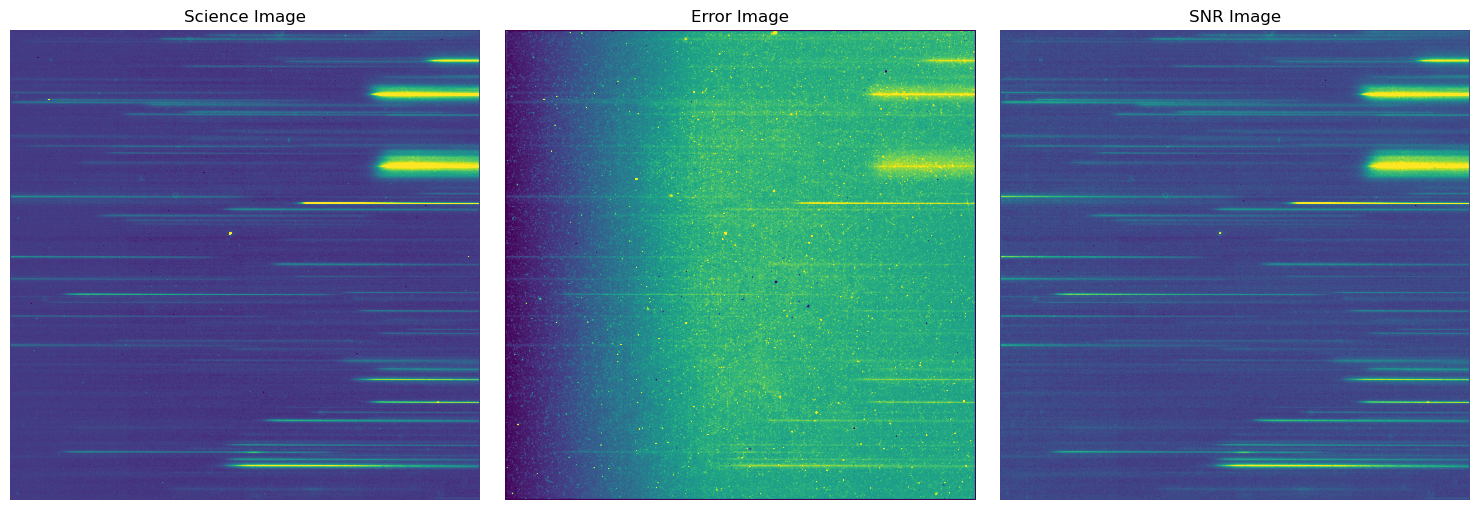

In [9]:
sci_data = fits.open(example)[1].data
err_data = fits.open(example)[2].data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


axes[0].imshow(np.nan_to_num(sci_data), vmin = np.nanpercentile(sci_data, 0.5), vmax = np.nanpercentile(sci_data, 99.5), origin = 'lower')
axes[0].set_title('Science Image')
axes[0].set_axis_off()



axes[1].imshow(np.nan_to_num(err_data), vmin = np.nanpercentile(err_data, 0.5), vmax = np.nanpercentile(err_data, 99.5), origin='lower')
axes[1].set_title('Error Image')
axes[1].set_axis_off()


axes[2].imshow(final_snr_map, vmin = np.nanpercentile(final_snr_map, 0.5), vmax = np.nanpercentile(final_snr_map, 99.5), origin='lower')
axes[2].set_title('SNR Image')
axes[2].set_axis_off()

plt.tight_layout()

# Show the plot
plt.show()


In [10]:
def grism_conf_preparation(x0 = 1024, y0 = 1024, pupil = 'R', 
                           fit_opt_fit = np.zeros(30), w_opt = np.zeros(16)):
    '''
    Prepare grism configuration, dxs, dys, wavelengths based on input (x0, y0) pixel postion
        and filter/pupil/module information.
    -----------------------------------------------
        Parameters
        ----------  
        x0, y0 : float
            Reference position (i.e., in direct image)
        
        pupil: 'R' or 'C'
            pupil of grism ('R' or 'C')
        
        fit_opt_fit: numpy.ndarray, shape: (30,)
            polynomial parameters in the perpendicular direction, used by function `fit_disp_order23` 
        
        w_opt: numpy.ndarray, shape: (16,)
            polynomial parameters in the dispersed direction, used by function `fit_disp_order32` 
        
        Returns
        -------
        
        dxs, dys : `~numpy.ndarray`
            offset of spectral pixel from the direct imaging position
        
        wavs: `~numpy.ndarray`
            Array of wavelengths corresponding to dxs and dys
    '''
    # Load the Grism Configuration file
    # GConf = grismconf.Config(os.environ['MIRAGE_DATA'] + "/nircam/GRISM_NIRCAM/V3/" +
    #                          "NIRCAM_%s_mod%s_%s.conf" % (filter, module, pupil))
    #wave_space = np.arange(2.39, 5.15, 0.01)
    wave_space = np.arange(3.8, 5.1, 0.01)
    disp_space = func_fit_wave(np.vstack((x0 * np.ones_like(wave_space), y0 * np.ones_like(wave_space), wave_space)), *w_opt)
    inverse_wave_disp = interpolate.UnivariateSpline(disp_space[np.argsort(disp_space)], wave_space[np.argsort(disp_space)], s = 0, k = 1)

    if pupil == 'R':
        dxs = np.arange(int(np.min(disp_space)), int(np.max(disp_space))) - x0%1
        # Compute wavelength of each of the pixels
        wavs = inverse_wave_disp(dxs)
        # Compute the dys values for the same pixels
        dys = fit_disp_order23(np.vstack((x0* np.ones_like(dxs), y0 * np.ones_like(dxs), dxs)), *fit_opt_fit)
        # dxs = np.arange(-1800, 1800, 1) - x0%1
        ## Compute the t values corresponding to the exact offsets (with old grism config)
        # ts = GConf.INVDISPX(order = '+1', x0 = x0, y0 = y0, dx = dxs)
        # dys = GConf.DISPY('+1', x0, y0, ts)
        # wavs = GConf.DISPL('+1', x0, y0, ts)
        # tmp_aper = np.max([0.2, 1.5 * tmp_re_maj * np.cos(tmp_pa), 1.5 * tmp_re_min * np.sin(tmp_pa)])
    elif pupil == 'C':
        # Compute the dys values for the same pixels
        dys = np.arange(int(np.min(disp_space)), int(np.max(disp_space))) - y0%1
        # Compute wavelength of each of the pixels
        wavs = inverse_wave_disp(dys)
        dxs = fit_disp_order23(np.vstack((x0* np.ones_like(dys), y0 * np.ones_like(dys), dys)), *fit_opt_fit)
        # dys = np.arange(-1800, 1800, 1) - y0%1
        ## Compute the t values corresponding to the exact offsets (with old grism config)
        # ts = GConf.INVDISPY(order = '+1', x0 = x0, y0 = y0, dy = dys)
        # dxs = GConf.DISPX('+1', x0, y0, ts)
        # wavs = GConf.DISPL('+1', x0, y0, ts)
    return (dxs, dys, wavs)

'''Lienar Function'''
linear = lambda x, k, b: x * k + b
'''gaussian function'''
gauss = lambda x, x0, flux, FWHM : (flux / FWHM / 1.064467) * np.exp(-(x - x0)**2 / (2 * (FWHM/2.354820)**2))
'''gaussian function + continuum'''
gauss_cont_prof = lambda x, x0, flux, FWHM, k, b : (flux / FWHM / 1.064467) * np.exp(-(x - x0)**2 / (2 * (FWHM/2.354820)**2)) + k * (x - 1024) + b


In [19]:
## dxs, dys, wavs = grism_conf_preparation(x0 = x0,  y0 = y0, pupil = tmp_pupil, 
 #                                               fit_opt_fit = fit_opt_fit, w_opt = w_opt)
### In this function, we fill the segmentation map with the id ###

#wave is the array of wavelenghts corresponding to dxs and dys
def make_extraction_for_seg(id, x0, y0, WRANGE, dxs, dys, wave, fwhm, img_snr, img_dq, header, img_line = None, pupil = 'R', n_procs = 4):
    
    w_min, w_max = WRANGE
    x_on_G_img = dxs + x0
    y_on_G_img = dys + y0
    
    if pupil not in ['C', 'R']: raise KeyError('pupil of grism should be either "R" or "C"! ')
    fwhm_int_pix = int(fwhm)
    
    ### region that we can extract spectra: 
    if pupil == 'R':
        cut_out_x_low = np.max(np.min(x_on_G_img), 5)
        cut_out_x_high = np.min(np.max(x_on_G_img), 2047 -6)
        cut_out_y_low = np.max(np.min(y_on_G_img - fwhm_int_pix),5)
        cut_out_y_high = np.min(np.max(y_on_G_img + fwhm_int_pix),2047 -6)
        
    if pupil == 'R':
        cut_out_x_low = np.max(np.min(x_on_G_img - fwhm_int_pix), 5)
        cut_out_x_high = np.min(np.max(x_on_G_img + fwhm_int_pix), 2047 -6)
        cut_out_y_low = np.max(np.min(y_on_G_img), 5)
        cut_out_y_high = np.min(np.max(y_on_G_img), 2047 -6)
    img_snr_shape = img_snr.shape
    ### construct a array that are full of nan ###
    #tmp_seg_2d = tmp_seg_2d[cut_out_y_low:cut_out_y_high, cut_out_x_low:cut_out_x_high]


    for i in range(cut_out_x_low, cut_out_x_high+1):
        for j in range(cut_out_y_low, cut_out_y_high+1):
            if img_snr[i][j] >= 2:
                if np.isnan(tmp_seg_2d[i][j]):
                    tmp_seg_2d[i][j] = id